In [7]:
import pyomo.opt 
import pyomo.environ as pe
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# 1.2.9 Método para análise estratégica: Análise estratégica de dados para alinhamento das outorgas portuárias

## Modelo custo de fluxo mínimo multiproduto em redes

### Primal

\begin{aligned}
& \underset{x_{ij}^k}{\text{minimizar}} & &\sum_{k \in OD}\sum_{(i,j) \in E} c_{ij}x_{ij}^k &\\
& \text{sujeito a}  & & \sum_{k\in K} x_{ij}^k \leq u_{ij} & \forall (i,j) \in E\\
&                   & & \sum_{i:(i,v)\in E} x_{iv}^k - \sum_{j:(v,j)\in E} x_{vj}^k = 0 & \forall v \in V, \forall k \in OD \; \mid \;v \notin OD_1 \cup OD_2\\
&                   & & \sum_{i:(i,v)\in E} x_{iv}^k - \sum_{j:(v,j)\in E} x_{vj}^k = d^k & \forall v \in V, \forall k \in OD \; \mid \;v \in OD_1 \\
&                   & & \sum_{i:(i,v)\in E} x_{iv}^k - \sum_{j:(v,j)\in E} x_{vj}^k = -d^k & \forall v \in V, \forall k \in OD \; \mid \;v \in OD_2 \\
&                   & & x_{ij}^k \geq 0 & \forall (i,j) \in E \quad \forall k \in OD.
\end{aligned}

### Dual

\begin{aligned}
& \underset{x_{ij}^k}{\text{maximizar}} & &\sum_{k \in OD}\sum_{v \in V} \pi_v^kd^k - \sum_{(i,j) \in E} d_{ij}\mu_{ij}&\\
& \text{sujeito a}  & & \pi_i^k - \pi_j^k - \mu_{ij} = c_{ij} & \forall (i,j) \in E, \; \forall k \in OD\\
&                   & & \pi_i^k \in \mathbb{R} \quad \mu_{ij} \geq 0
\end{aligned}

## Dados de entrada

In [8]:
origens = ["SP", "SC"]
destinos = ["USA", "EU"]
portos = ["Itapoá", "SFS"]

origem_destino = [(o,d) for o in origens for d in destinos]
demanda_origem_destino = {  origem_destino[0]:4, 
                            origem_destino[1]:5,
                            origem_destino[2]:2, 
                            origem_destino[3]:1 }

#Conjunto E

portos_v = [(p+"-in", p+"-out") for p in portos]

arcos = [(origens[0], portos_v[0][0]), (origens[0], portos_v[1][0]), (origens[1], portos_v[0][0]), (origens[1], portos_v[1][0]),
         (portos_v[0][0], portos_v[0][1]), (portos_v[1][0], portos_v[1][1]),
         (portos_v[0][1], destinos[0]), (portos_v[1][1], destinos[0]), (portos_v[0][1], destinos[1]), (portos_v[1][1], destinos[1]),
         (origens[0], destinos[0]), (origens[0], destinos[1]), (origens[1], destinos[0]), (origens[1], destinos[1])]
#Conjunto V
vertices = list(set().union(origens,destinos))
for porto_v in portos_v:
    vertices = list(set().union(vertices,porto_v))

# c_ij
custo_transporte = {arcos[0]:.505, 
                    arcos[1]:.190,
                    arcos[2]:.365,
                    arcos[3]:.265,
                    arcos[4]:.002,
                    arcos[5]:.001,
                    arcos[6]:.345,
                    arcos[7]:.525,
                    arcos[8]:.210,
                    arcos[9]:.245,
                    arcos[10]:1000,
                    arcos[11]:1000,
                    arcos[12]:1000,
                    arcos[13]:1000}

# u_ij
capacidades_arcos = {arcos[0]:2,
                     arcos[1]:2,
                     arcos[2]:2,
                     arcos[3]:2,
                     arcos[4]:4,
                     arcos[5]:2,
                     arcos[6]:5,
                     arcos[7]:5,
                     arcos[8]:5,
                     arcos[9]:5,
                     arcos[10]:1000,
                     arcos[11]:1000,
                     arcos[12]:1000,
                     arcos[13]:1000}

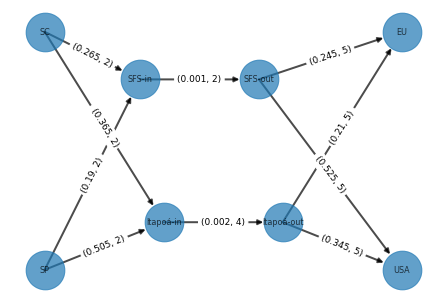

In [51]:
def create_networkx_nodes(rede:nx.DiGraph(), nos:list, x:int, y:int=0):
    for index, no in enumerate(nos):
        rede.add_node(no, pos=(x, index*5 if y == 0 else y))        
def create_networkx(edge_labels: dict):        
    rede = nx.DiGraph()        
    create_networkx_nodes(rede, origens, 0)
    create_networkx_nodes(rede, [portos_v[0][0]], 10, 1)
    create_networkx_nodes(rede, [portos_v[0][1]], 20, 1)
    create_networkx_nodes(rede, [portos_v[1][0]], 8, 4)
    create_networkx_nodes(rede, [portos_v[1][1]], 18, 4)
    create_networkx_nodes(rede, destinos, 30)    
    for edge in arcos:
         if custo_transporte[edge] < 1000:            
                rede.add_edge(*edge, weight=custo_transporte[edge], capacity=capacidades_arcos[edge])
    pos=nx.get_node_attributes(rede,'pos')
    nx.draw(rede, pos, with_labels=True, node_size=1500, alpha=0.7, arrows=True, font_size=8, width=[2 for u,v in rede.edges()])        
    labels_return=nx.draw_networkx_edge_labels(rede, pos,edge_labels=edge_labels,font_size=9)
    return rede

edge_labels = {}
for edge in arcos:
    if custo_transporte[edge] < 1000:                    
        edge_labels[edge] = (custo_transporte[edge], capacidades_arcos[edge])   
rede = create_networkx(edge_labels)

## Formulação de modelo concreto: Custo mínimo multi produto em redes 

In [11]:
modelo = pe.ConcreteModel(name="(demanda_porto)")
                  
modelo.node_set = pe.Set( initialize=vertices )
modelo.edge_set = pe.Set( initialize=arcos, dimen=2)
modelo.commodity_set = pe.Set( initialize=origem_destino, dimen=2)
modelo.dual = pe.Suffix(direction=pe.Suffix.IMPORT)

modelo.var_indexes = pe.Set(initialize=modelo.edge_set*modelo.commodity_set)
modelo.var = pe.Var(modelo.var_indexes, within=pe.NonNegativeReals)

def objetivo(m):
    return sum(custo_transporte[(index[0], index[1])] * m.var[index] for index in modelo.var_indexes)     
modelo.obj = pe.Objective(rule=objetivo, sense=pe.minimize)

def conserva_fluxo(m, i, o, d):
    from_i = [v for v in arcos if v[0] == i]
    to_i = [v for v in arcos if v[1] == i]
    q =  demanda_origem_destino[(o,d)] if i == o else -demanda_origem_destino[(o,d)] if i == d else 0
    return sum(m.var[v,(o,d)] for v in from_i) - sum(m.var[v,(o,d)] for v in to_i) == q

modelo.conserva_fluxo_indexes = pe.Set(initialize=modelo.node_set*modelo.commodity_set)
modelo.flowConservation = pe.Constraint(modelo.conserva_fluxo_indexes, rule=conserva_fluxo)

def capacidades(m, e1,e2):
    return sum(m.var[e1,e2,o,d] for (o,d) in modelo.commodity_set) <= capacidades_arcos[(e1,e2)]
modelo.capacidade_arco = pe.Constraint(modelo.edge_set, rule=capacidades)
 
solver = pyomo.opt.SolverFactory('cbc')
results = solver.solve(modelo)

## Apresenta resultados
### Análise dos Fluxos

{'Itapoá': 4.0, 'SFS': 2.0}


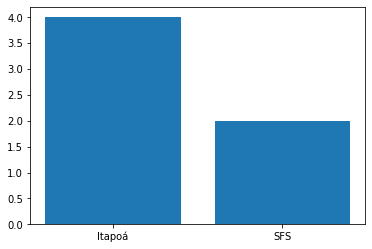

In [12]:
demanda_porto = {}
for porto in portos:
    total = 0
    for var_index in modelo.var_indexes:
        if (var_index[0], var_index[1]) == (porto+"-in", porto+"-out"):
            total += modelo.var[var_index].value
    demanda_porto[porto] = total

print(demanda_porto)

from matplotlib import rcParams
color = 'black'
rcParams['xtick.color'] = color
rcParams['ytick.color'] = color
rcParams['axes.labelcolor'] = color
rcParams['axes.edgecolor'] = color
plt.bar(range(len(demanda_porto)),list(demanda_porto.values()),tick_label=list(demanda_porto.keys()))
plt.show()
    
# for con in modelo.component_map(pe.Constraint).itervalues():
#     print(con.pprint())

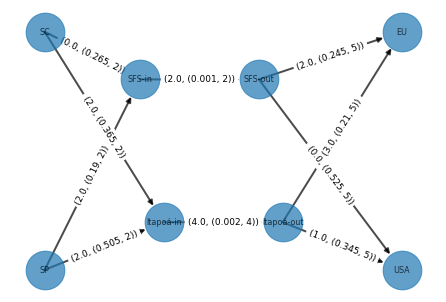

In [52]:
fluxo_arco = {}
for var_index in modelo.var_indexes:
    if fluxo_arco.get((var_index[0], var_index[1])) is not None:
        fluxo_arco[(var_index[0], var_index[1])] = fluxo_arco[(var_index[0], var_index[1])] + modelo.var[var_index].value
    else:
        fluxo_arco[(var_index[0], var_index[1])] = modelo.var[var_index].value

edge_labels = {}
for edge in arcos:
    if custo_transporte[edge] < 1000:                    
        edge_labels[edge] = (fluxo_arco[edge], (custo_transporte[edge], capacidades_arcos[edge]))
rede_fluxo = create_networkx(edge_labels)    

In [ ]:
#print(results)
# print(results.solver.status)
# modelo.x.pprint()
#print(objetivo(modelo))
#print(conserva_fluxo(modelo, vertices, origem_destino))

modelo.display()

#modelo.pprint()

# for var_index in modelo.var_indexes:
#     if modelo.var[var_index].value != 0:
#         print(var_index,modelo.var[var_index].value)    

### Análise das variáveis duais

In [16]:
for c in modelo.component_objects(pe.Constraint, active=True):
    print ("   Restrição",c)
    for index in c:
        print ("      ", index, modelo.dual[c[index]])
#modelo.dual.display()

   Restrição flowConservation
       ('SP', 'SP', 'USA') 1000.0
       ('SP', 'SP', 'EU') 0.0
       ('SP', 'SC', 'USA') 0.0
       ('SP', 'SC', 'EU') 0.0
       ('Itapoá-out', 'SP', 'USA') 0.345
       ('Itapoá-out', 'SP', 'EU') -999.79
       ('Itapoá-out', 'SC', 'USA') 0.345
       ('Itapoá-out', 'SC', 'EU') -999.655
       ('SFS-out', 'SP', 'USA') 0.245
       ('SFS-out', 'SP', 'EU') -999.755
       ('SFS-out', 'SC', 'USA') 0.525
       ('SFS-out', 'SC', 'EU') -999.62
       ('Itapoá-in', 'SP', 'USA') 0.347
       ('Itapoá-in', 'SP', 'EU') -999.788
       ('Itapoá-in', 'SC', 'USA') 0.347
       ('Itapoá-in', 'SC', 'EU') -999.653
       ('SFS-in', 'SP', 'USA') 999.6
       ('SFS-in', 'SP', 'EU') -0.4
       ('SFS-in', 'SC', 'USA') 999.88
       ('SFS-in', 'SC', 'EU') -0.265
       ('SC', 'SP', 'USA') 0.0
       ('SC', 'SP', 'EU') -0.135
       ('SC', 'SC', 'USA') 1000.0
       ('SC', 'SC', 'EU') 0.0
       ('EU', 'SP', 'USA') 0.135
       ('EU', 'SP', 'EU') -1000.0
       ('EU', 'SC

## Usar estrutura de dados melhor para receber dados de entrada

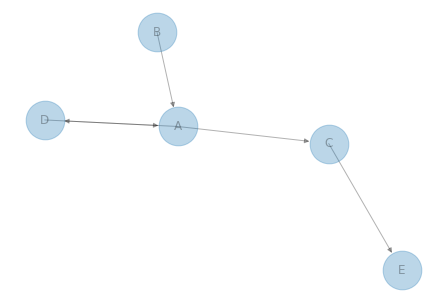

In [17]:
## Building a network from a DataFrame
# ------- DIRECTED
 
# Build a dataframe with your connections
# This time a pair can appear 2 times, in one side or in the other!
df = pd.DataFrame({ 'from':['D', 'A', 'B', 'C','A'], 'to':['A', 'D', 'A', 'E','C']})
df
 
# Build your graph. Note that we use the DiGraph function to create the graph!
G=nx.from_pandas_edgelist(df, 'from', 'to', create_using=nx.DiGraph() )
 
# Make the graph
nx.draw(G, with_labels=True, node_size=1500, alpha=0.3, arrows=True)
 
# &nbsp;
 
# # ------- UNDIRECTED
 
# # Build a dataframe with your connections
# # This time a pair can appear 2 times, in one side or in the other!
# df = pd.DataFrame({ 'from':['D', 'A', 'B', 'C','A'], 'to':['A', 'D', 'A', 'E','C']})
# df
 
# # Build your graph. Note that we use the Graph function to create the graph!
# G=nx.from_pandas_dataframe(df, 'from', 'to', create_using=nx.Graph() )
 
# # Make the graphnx.draw(G, with_labels=True, node_size=1500, alpha=0.3, arrows=True)
# plt.title("UN-Directed")

/home/eder/py-workspace/competition-studies/.venv/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \


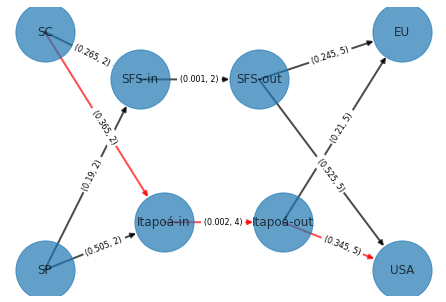

In [44]:
for edge in rede.edges():
    rede[edge[0]][edge[1]]['color']='black'
path = nx.shortest_path(rede, 'SC', 'USA', weight='weight')
for i in range(1,len(path)):
    rede[path[i-1]][path[i]]['color']='red'    
colors = [rede[u][v]['color'] for u,v in rede.edges()]
weights = [2 for u,v in rede.edges()]
nx.draw(rede, pos, with_labels=True, node_size=3500, alpha=0.7, arrows=True, edge_color=colors, width=weights)
nx.draw_networkx_edge_labels(rede, pos,edge_labels=edge_labels, font_size=8)
plt.show()